In [26]:
import numpy as np
import pandas as pd
from pathlib import Path
from functions import *

# load data
N_ASSETS_PER_SECTOR = 2
INCLUDE_SECTORS = [
    "energy",
    "finance"
    "healthcare",
    "indices",
    "industrials",
    "information",
    "materials",
    "real_estate",
    "utilities"
]
MIN_DATE = pd.Timestamp('2000-01-01')
PCT_TRAINING_DATA = 0.85

data = []
symbol_names = []
common_idx = None

print('PATH:', Path.cwd())

for dir in (Path.cwd() / 'realData').iterdir():
    sector = dir.name.split('\\')[-1]
    if sector in INCLUDE_SECTORS:
        assets = list(dir.iterdir())
        chosen = np.random.choice(assets, N_ASSETS_PER_SECTOR)
        for c in chosen:
            df = pd.read_csv(c, index_col=0)
            df.index = pd.to_datetime(df.index)
            df = df[df.index >= MIN_DATE]
            data.append(df)
            symbol_names.append(c.name.split('\\')[-1])
            if common_idx is None:
                common_idx = df.index
            else:
                common_idx = common_idx.intersection(df.index)

data_filtered = []
for df in data:
    df = df[df.index.isin(common_idx)]
    data_filtered.append(df)


PATH: c:\Projects\EM\PortfolioModel


In [27]:

T_total = len(data_filtered[0])
T_train = int(T_total * PCT_TRAINING_DATA)
T_test = T_total - T_train
returns_training = np.empty((T_train, len(data_filtered)))
returns_testing = np.empty((T_test, len(data_filtered)))
for i, df in enumerate(data_filtered):
    returns = df["Close"].pct_change()
    returns.iloc[0] = 0
    returns_training[:, i] = returns[:T_train]
    returns_testing[:, i] = returns[T_train:]

print(returns_training)
print(returns_training.shape)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.03013658  0.01590123  0.01351939 ...  0.03734318  0.00878112
  -0.0047407 ]
 [-0.02365011  0.02794234 -0.01750978 ... -0.03565286  0.00797984
  -0.0023101 ]
 ...
 [-0.02314521 -0.00976581  0.00799175 ...  0.00793262 -0.01309212
  -0.01453774]
 [-0.01505744  0.00221039  0.01281463 ...  0.02434815 -0.03062355
  -0.00501265]
 [-0.00382205 -0.00593818 -0.00015694 ... -0.00512192 -0.01120984
   0.00518202]]
(3281, 14)


Compute returns and cumulative returns per asset

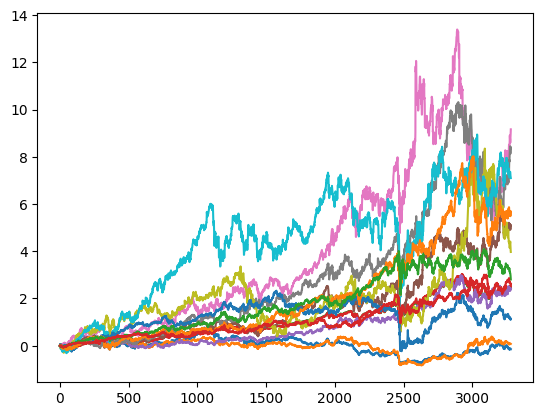

In [28]:
import matplotlib.pyplot as plt

cum_returns_train = (pd.DataFrame(returns_training) + 1).cumprod() - 1

fig, ax = plt.subplots()
N = len(data_filtered)
for i in range(N):
    ax.plot(cum_returns_train.values[:, i])


plt.show()

Because right now we obviously don't have access to the true regime transition probabilities (we're dealing with real data now), we will only be able to estimate the transition probabilities by using k-means clustering.

In [29]:
M = 3 # number of states, we take 3 here just like in simulated environment
T = returns_training.shape[0]

calc_volatility = pd.DataFrame(returns_training).rolling(30, min_periods=0).std()
calc_volatility.iloc[0] = calc_volatility.iloc[1]
clusters, centers, est_regimes = k_means(calc_volatility.values, M)
est_regimes = np.array(est_regimes)

mus = np.empty((M, N))

# mus: shape M x N
# clusters: shape M x (num_vectors_in_cluster) x N
Sigma = np.empty((M, N, N))

for m in range(M):
    # find returns corresponding to regime m
    reg_returns = returns_training[est_regimes == m, :]
    
    mus[m, :] = reg_returns.mean(axis=0)
    cluster = np.array(clusters[m])
    Sigma[m, :, :] = np.cov(cluster, rowvar=False)

# construct the estimated version of A (using estimated regime sequence)
A = np.zeros((M, M))
pi = np.zeros(M)
for m in range(len(est_regimes[:-1])):
    cur_est_regime = est_regimes[m]
    next_est_regime = est_regimes[m + 1]
    A[cur_est_regime, next_est_regime] += 1
    pi[cur_est_regime] += 1
A_sum = A.sum(axis=1)
for n in range(M):
    A[n, :] /= A_sum[n]
pi /= pi.sum()

print(A)

[[9.43983402e-01 5.60165975e-02 0.00000000e+00]
 [2.24913495e-02 9.51557093e-01 2.59515571e-02]
 [6.09013398e-04 1.82704019e-02 9.81120585e-01]]


Run the algorithm

In [ ]:

pct_change_ll_tol = 1e-06
n_attempts = 100
max_attempt_per_iter = 10

# noise addition to initial parameter guesses
A_noise_std = 0.2
pi_noise_std = 0.2
Sigma_noise_std = 0.5

# this will store data from every run
# structure: list of lists (inner list = data per iteration)
ll_list = []

# these will store data from every run
# stucture: list of floats (one per attempt, not one per iteration)
pct_states_matched_viterbi = []
frac_correct_states_predicted_list = []
all_predicted_obs = []


tt = []

for attempt in range(n_attempts):

    prev_ll = 1.0
    log_ll = 2.0

    # initialize parameters

    # choose diagonal values of A randomly
    A_est = np.empty((M, M))
    for m in range(M):
        diagval = np.clip(A[m, m] + np.random.normal(0, A_noise_std), 0.01, 0.99)
        A_est[m, :] = (1 - diagval) / (M - 1)
        A_est[m, m] = diagval
    loga = np.log(A_est)

    mus_std = np.empty((M, N))
    mus_std_vals = mus.std(axis=1)
    for i in range(N):
        mus_std[:, i] = mus_std_vals

    k = np.random.normal(np.zeros((M, N)), mus_std, (M, N))
    mus_est = mus + k

    Sigma_est = Sigma.copy()
    for m in range(M):
        Sigma_est[m, :, :] = np.clip(Sigma[m, :, :] + Sigma_noise_std * np.eye(N), a_min=1e-5, a_max=10)

    print(f"Attempt {attempt} sigma est: {Sigma_est}")
    
    #print('COMPUTING LOGB USING MUS EST:'); print(mus_est); print('AND SIGMA EST:'); print(Sigma_est)
    print('SHAPRES:')
    print(mus_est.shape)
    print(Sigma_est.shape)
    logb = compute_b(mus_est, Sigma_est, returns_training, T_test, M)
    B_est = np.exp(logb)

    pi_est = pi + np.random.normal(0, pi_noise_std, M)
    pi_est /= pi_est.sum()
    pi_est = np.clip(pi_est, 1e-10, None)
    logpi = np.log(pi_est)

    # store some metrics for each iterion step
    this_diff_norms_A = []
    this_diff_norms_B = []
    this_diff_norms_pi = []
    this_attempt_ll_list = []

    this_attempt_count = 0

    print('first mu est:', mus_est)

    while abs(prev_ll - log_ll) / abs(prev_ll) > pct_change_ll_tol and this_attempt_count < max_attempt_per_iter:
        prev_ll = log_ll

        # E step
        logalpha, scaling = forward(loga, logb, T_test, M, logpi)
        #print('LOGALPHA:'); print(logalpha)
        #print('HAVING USED LOGPI:'); print(logpi)
        #print('AND LOGA AND LOGB:'); print(loga); print(logb)
        logbeta = backward(loga, logb, T_test, M, scaling)
        #print('LOGBETA:'); print(logbeta)
        loggamma = compute_gamma(logalpha, logbeta, T_test, M)
        logxi = compute_xi(logalpha, logbeta, loga, logb, T_test, M)

        # M step
        loga = compute_a(loggamma, logxi, T_test, M)
        mus_est, Sigma_est = compute_mus_sigmas(loggamma, returns_training, T_test, M, N)
        print(f"Attempt {attempt} and iter count {this_attempt_count} sigma est: {Sigma_est}, having used loggamma: {loggamma}")

        logb = compute_b(mus_est, Sigma_est, returns_training, T_test, M)
        logpi = loggamma[0, :]

        # storing metrics for each iteration
        #log_ll = np.logaddexp.reduce(logalpha[-1, :])
        log_ll = np.sum(scaling)
        #print('SCALING SEQUENCE:'); print(scaling)
        this_attempt_ll_list.append(log_ll)
        this_attempt_count += 1

    
    A = np.exp(loga)
    A /= A.sum(axis=1, keepdims=True)
    B = np.exp(logb)
    B /= B.sum(axis=1, keepdims=True)
    pi = np.exp(logpi)
    pi /= pi.sum()

    A = np.clip(A, 1e-10, 1)
    B = np.clip(B, 1e-10, 1)

    # store data from this attempt
    #ll_list.append([this_attempt_ll_list[i+1] - this_attempt_ll_list[i] for i in range(len(this_attempt_ll_list)-1)])
    ll_list.append(this_attempt_ll_list)

    ##

    # assuming we have access to the future observations, we will test the model using the viterbi path
    # algorithm, to see how well it can predict the hidden state variables, given these observations

    # assuming we are at time T and we wanted to predict the future states and observations up untill
    # t = T_test, we will try to predict these values and see how well the model generalizes
    predicted_obs = np.empty((T_test, N))
    predicted_states = np.empty(T_test, dtype=int)

    states_p_dist = np.exp(loggamma[-1, :])
    predicted_states[0] = np.argmax(states_p_dist)
    predicted_obs[0, :] = states_p_dist @ mus_est

    # generate prediction states and observations using A and B
    for k in range(1, T_test):
        
        # prediction of states
        states_p_dist = states_p_dist @ A
        states_p_dist /= states_p_dist.sum()
        predicted_states[k] = np.argmax(states_p_dist)
        # determine the predicted observation by taking the most likely observation, given the
        # predicted state value
        predicted_obs[k, :] = states_p_dist @ mus_est
        

Attempt 0 sigma est: [[[5.00004739e-01 1.00000000e-05 1.00000000e-05 1.00000000e-05
   1.00000000e-05 1.00000000e-05 1.00000000e-05 1.00000000e-05
   1.00000000e-05 1.00000000e-05 1.00000000e-05 1.00000000e-05
   1.00000000e-05 1.00000000e-05]
  [1.00000000e-05 5.00004002e-01 1.00000000e-05 1.00000000e-05
   1.00000000e-05 1.00000000e-05 1.00000000e-05 1.00000000e-05
   1.00000000e-05 1.00000000e-05 1.00000000e-05 1.00000000e-05
   1.00000000e-05 1.00000000e-05]
  [1.00000000e-05 1.00000000e-05 5.00001991e-01 1.00000000e-05
   1.00000000e-05 1.00000000e-05 1.00000000e-05 1.00000000e-05
   1.00000000e-05 1.00000000e-05 1.00000000e-05 1.00000000e-05
   1.00000000e-05 1.00000000e-05]
  [1.00000000e-05 1.00000000e-05 1.00000000e-05 5.00001972e-01
   1.00000000e-05 1.00000000e-05 1.00000000e-05 1.00000000e-05
   1.00000000e-05 1.00000000e-05 1.00000000e-05 1.00000000e-05
   1.00000000e-05 1.00000000e-05]
  [1.00000000e-05 1.00000000e-05 1.00000000e-05 1.00000000e-05
   5.00007476e-01 1.0000

ValueError: operands could not be broadcast together with shapes (579,1) (3281,14) 

Plot the log-likelyhood values of each attempt

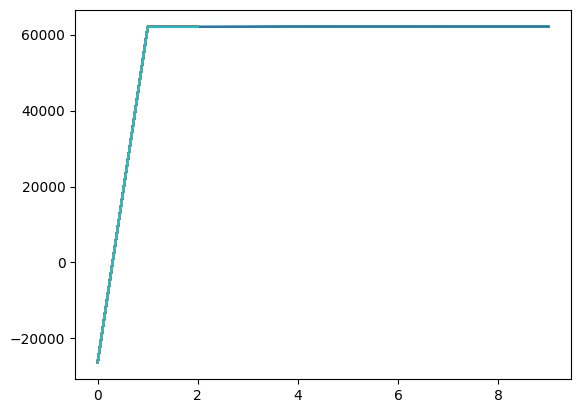

In [31]:

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for i in range(n_attempts):
    ax.plot(list(range(len(ll_list[i]))), ll_list[i])

plt.show()

Compute estimated regime sequence for testing data, and compare with the estimated "future" regime sequence (predicted_states).

We have to keep in mind that while we may get a view of the accuracy of the model regarding regime detection, the "true" regimes also come from k-means clustering, so this is still an estimation. We are then comparing our estimation, with another estimation. So this may not reflect the true performance of the model when it comes to regime detection.

0.457685664939551
[]


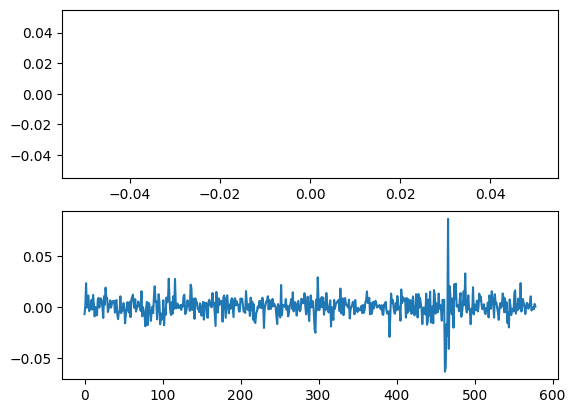

In [ ]:
# first determine the estimated regime sequence for the testing data
volatility_testing = pd.DataFrame(returns_testing).rolling(30, min_periods=0).std()
volatility_testing.iloc[0] = volatility_testing.iloc[1]
clusters, centers, regimes_testing = k_means(volatility_testing.values, M)
regimes_testing = np.array(regimes_testing)

# compare
pct_correct = 1 - np.count_nonzero(np.bitwise_xor(regimes_testing, predicted_states)) / T_test
print(pct_correct)

fig, (ax1, ax2) = plt.subplots(2)
ax1.bar(range(len(frac_correct_states_predicted_list)), frac_correct_states_predicted_list, label="Pct correctly predicted states")

# print(returns_eval.mean(axis=1))
for n in range(len(all_predicted_obs)):
    ax2.plot(all_predicted_obs[n].mean(axis=1))
ax2.plot(returns_testing.mean(axis=1))

plt.show()
